In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


import tensorflow_datasets as tfds

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Input, Dropout, RandomFlip, RandomRotation, Resizing, Rescaling
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.optimizers import Adam




In [2]:
dataset, dataset_info = tfds.load('malaria', with_info=True,
                                  as_supervised=True,
                                  shuffle_files = True,
                                  split=['train'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incompleteCQLW6M/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [3]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)

  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

  val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
  val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))

  test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))
  return train_dataset, val_dataset, test_dataset

In [4]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO )




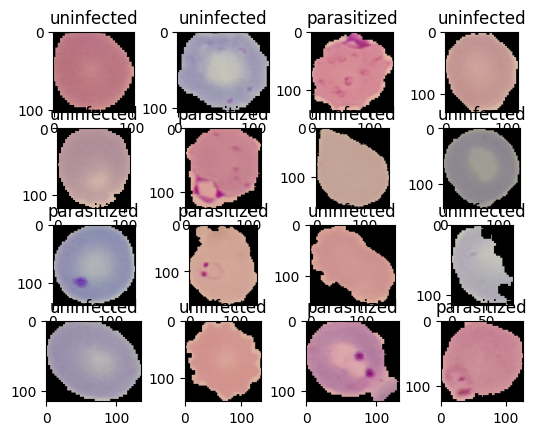

In [5]:
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 4, i + 1)

  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  # plt.axis('off')



In [6]:
I_size = 244

def resizing_rescaling(image , label):
  return tf.image.resize(image , (I_size , I_size))/255 , label

In [7]:
train_dataset = train_dataset.map(resizing_rescaling)
val_dataset = val_dataset.map(resizing_rescaling)
test_dataset = test_dataset.map(resizing_rescaling)

In [8]:
for image, label in train_dataset.take(1):
  print(image, label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(244, 244, 3), dtype=float32) tf.Tensor(0, shape=(), dtype=int64)


In [9]:
train_dataset = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 244, 244, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [10]:
model = tf.keras.Sequential([
    InputLayer(input_shape=(I_size, I_size, 3)),

    Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Flatten(),

    Dense(100, activation='relu'),
    BatchNormalization(),
    Dense(10, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 242, 242, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 242, 242, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 121, 121, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 119, 119, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 119, 119, 16)      64        
 chNormalization)                                                
                                                        

In [11]:
model.compile(optimizer = Adam(learning_rate = 0.01),
              loss = BinaryCrossentropy(),
              metrics = 'accuracy' )


In [12]:
history = model.fit(train_dataset , validation_data = val_dataset , epochs = 10 , verbose = 1 )

Epoch 1/10
689/689 [==============================] - 59s 71ms/step - loss: 0.3131 - accuracy: 0.8711 - val_loss: 0.2097 - val_accuracy: 0.9343
Epoch 2/10
689/689 [==============================] - 50s 72ms/step - loss: 0.2071 - accuracy: 0.9314 - val_loss: 0.2206 - val_accuracy: 0.9485
Epoch 3/10
689/689 [==============================] - 51s 74ms/step - loss: 0.2014 - accuracy: 0.9315 - val_loss: 1.5565 - val_accuracy: 0.4944
Epoch 4/10
689/689 [==============================] - 56s 81ms/step - loss: 0.2016 - accuracy: 0.9327 - val_loss: 140.8687 - val_accuracy: 0.5111
Epoch 5/10
689/689 [==============================] - 56s 81ms/step - loss: 0.1586 - accuracy: 0.9497 - val_loss: 666.1699 - val_accuracy: 0.8740
Epoch 6/10
689/689 [==============================] - 57s 82ms/step - loss: 0.1458 - accuracy: 0.9530 - val_loss: 12.0875 - val_accuracy: 0.9543
Epoch 7/10
689/689 [==============================] - 53s 77ms/step - loss: 0.1479 - accuracy: 0.9526 - val_loss: 27.6803 - val_acc

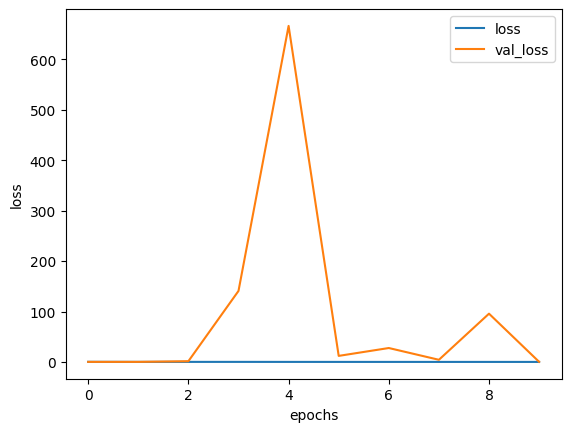

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss' ,'val_loss'])

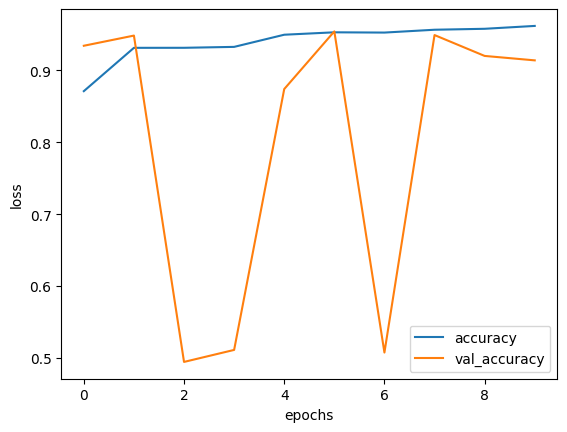

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['accuracy' ,'val_accuracy'])

In [15]:
test_dataset = test_dataset.batch(1)

In [16]:
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 244, 244, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [17]:
model.evaluate(test_dataset)

2757/2757 [==============================] - 22s 4ms/step - loss: 0.3018 - accuracy: 0.9159


[0.3018306791782379, 0.9158505797386169]

In [19]:
model.predict(test_dataset.take(1))[0][0]

1/1 [==============================] - 11s 11s/step


0.002861995

In [24]:
def check(x):
    if x < 0.5:
        return 'P'
    else:
        return 'U'


In [25]:
check(model.predict(test_dataset.take(1)))

1/1 [==============================] - 11s 11s/step


'P'

1/1 [==============================] - 0s 28ms/step


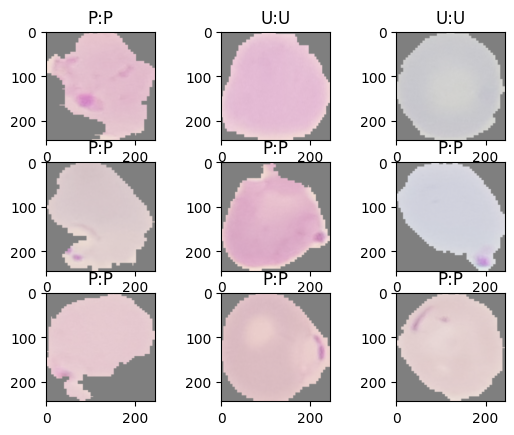

In [26]:


for i, (image, label) in enumerate(test_dataset.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow((image[0] + 1) / 2)  # Rescale pixel values if necessary
    plt.title(f"{check(label.numpy()[0])}:{check(model.predict(image)[0][0])}")


plt.show()

